All imports

In [ ]:
# %pip install torch
# %pip install seaborn


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms

In [ ]:
def train(network,  data_generator, loss_function, optimize, logging = 200):
  network.train() #updates any network layers that behave differently in training and execution
  avg_loss = 0
  num_batches = 0
  for batch, (input_data, target_output) in enumerate(data_generator):
    input_data, target_output = input_data.to(device), target_output.to(device)
    optimizer.zero_grad()                            # Gradients need to be reset each batch
    prediction = network(input_data)                 # Forward pass: compute the output class given a image
    loss = loss_function(prediction, target_output)  # Compute the loss: difference between the output and correct result
    loss.backward()                                  # Backward pass: compute the gradients of the model with respect to the loss
    optimizer.step()
    avg_loss += loss.item()
    num_batches += 1
    if ((batch+1)%logging == 0): print('Batch [%d/%d], Train Loss: %.4f' %(batch+1, len(data_generator.dataset)/len(target_output), avg_loss/num_batches))
  return avg_loss/num_batches

def test(network, test_loader, loss_function):
  network.eval() #updates any network layers that behave differently in training and execution
  test_loss = 0
  num_batches = 0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = network(data)
      test_loss += loss_function(output, target).item()
      pred = output.data.max(1, keepdim=True)[1]
      num_batches += 1
  test_loss /= num_batches
  #print('\nTest set: Avg. loss: {:.4f})\n'.format(test_loss))
  return test_loss

def computeLabelAccuracy(networkModel, data_loader, label_text=""):
  test_loss = 0
  correct = 0
  networkModel.eval()
  with torch.no_grad():
    for data, target in data_loader:
      data, target = data.to(device), target.to(device)
      output = networkModel(data)
      pred = output.data.max(1, keepdim=True)[1]  #Check if the maximum/largest output class matches the label
      correct += pred.eq(target.data.view_as(pred)).sum()
  print('\n{}: Accuracy: {}/{} ({:.1f}%)'.format(
    label_text, correct, len(data_loader.dataset),
    100. * correct / len(data_loader.dataset)))

def drawPredictionsCIFAR10(networkModel, dataset, num_rows=6, num_cols = 10, skip_batches=0):
  #Plot some of the testing results
  networkModel.eval()
  data_generator = torch.utils.data.DataLoader(testing_dataset, batch_size=num_rows*num_cols)
  data_enumerator = enumerate(data_generator)
  for i in range(skip_batches):
     _, (images,labels) = next(data_enumerator) #skip a few batches if needed
  _, (images,labels) = next(data_enumerator)
  images, labels = images.to(device), labels.to(device)
  with torch.no_grad():
    pred_catigories = networkModel(images) #all 10 values
    pred_labels = pred_catigories.data.max(1, keepdim=True)[1] #only the highest value is the final prediction
  for row in range(num_rows):
    fig = plt.figure(figsize=(num_cols+6,5)) #adjust the plot size
    for i in range(num_cols):
      plt.subplot(1,num_cols,i+1)
      cur = i + row*num_cols
      #plt.tight_layout()
      drawColor = 'black'
      if pred_labels[cur].item() != labels[cur]:
        drawColor = 'red'
      img = images[cur] / 2 + 0.5     # unnormalize
      npimg = img.cpu().numpy()
      plt.imshow(np.transpose(npimg, (1, 2, 0)))  #, interpolation='none'
      plt.title(" O: {},\n L: {}".format(classes[pred_labels[cur].item()],classes[labels[cur]]), color=drawColor)
      plt.xticks([])
      plt.yticks([])

In [ ]:
from torch.optim.lr_scheduler import StepLR


In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def logResults(epoch, num_epochs, train_loss, train_loss_history, test_loss, test_loss_history, epoch_counter, print_interval=1000):
  if (epoch%print_interval == 0):  print('Epoch [%d/%d], Train Loss: %.4f, Test Loss: %.4f' %(epoch+1, num_epochs, train_loss, test_loss))
  train_loss_history.append(train_loss)
  test_loss_history.append(test_loss)
  epoch_counter.append(epoch)

def graphLoss(epoch_counter, train_loss_hist, test_loss_hist, loss_name="Loss", start = 0):
  fig = plt.figure()
  plt.plot(epoch_counter[start:], train_loss_hist[start:], color='blue')
  plt.plot(epoch_counter[start:], test_loss_hist[start:], color='red')
  plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
  plt.xlabel('#Epochs')
  plt.ylabel(loss_name)

# def trainAndGraph(network, training_generator, testing_generator, loss_function, optimizer, num_epochs, learning_rate, logging_interval=1):
#   #Arrays to store training history
#   test_loss_history = []
#   epoch_counter = []
#   train_loss_history = []
#   last_loss = 999999
#   best_loss = 999999
#   for epoch in range(num_epochs):
#     train_loss = train(network, training_generator, loss_function, optimizer)
#     validation_loss = test(network, validation_generator, loss_function)
#     avg_loss = train(network, training_generator, loss_function, optimizer)
#     test_loss = test(network, testing_generator, loss_function)
#     logResults(epoch, num_epochs, avg_loss, train_loss_history, test_loss, test_loss_history, epoch_counter, logging_interval)
#     # if (test_loss > last_loss):
#     #   break
#     if (test_loss < best_loss):
#       best_loss = test_loss
#       torch.save(network.state_dict(), 'best_model.pt')
#     last_loss = test_loss
#     old_params = network.parameters()

#   graphLoss(epoch_counter, train_loss_history, test_loss_history)

def validate(network, validation_loader, loss_function):
    network.eval()
    validation_loss = 0
    with torch.no_grad():
        for data, target in validation_loader:
            data, target = data.to(device), target.to(device)
            output = network(data)
            validation_loss += loss_function(output, target).item()
    validation_loss /= len(validation_loader)
    return validation_loss

def trainAndGraph(network, training_generator, validation_generator, testing_generator, loss_function, optimizer, num_epochs, learning_rate, logging_interval=1):
    scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
    test_loss_history = []
    val_loss_history = []
    train_loss_history = []
    epoch_counter = []
    best_loss = float('inf')
    for epoch in range(num_epochs):
        train_loss = train(network, training_generator, loss_function, optimizer)
        val_loss = validate(network, validation_generator, loss_function)
        test_loss = test(network, testing_generator, loss_function)
        if (epoch % logging_interval == 0):
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Test Loss: {test_loss:.4f}')
        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)
        test_loss_history.append(test_loss)
        epoch_counter.append(epoch)
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(network.state_dict(), 'best_model.pt')
        scheduler.step()
    graphLoss(epoch_counter, train_loss_history, val_loss_history, "Training and Validation Loss")
    graphLoss(epoch_counter, train_loss_history, test_loss_history, "Training and Test Loss")



In [ ]:
use_cuda = torch.cuda.is_available()
print("Using GPU?:",use_cuda)
if (use_cuda):
  print("GPU Name:",torch.cuda.get_device_name())
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

Using GPU?: True
GPU Name: Tesla T4


In [ ]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

image_w = 32
image_h = 32
batch_size = 64

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) #RGB mean and std. dev

training_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testing_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

train_size = int(0.8 * len(training_dataset))  # 80% of data for training
validation_size = len(training_dataset) - train_size  # 20% for validation
train_dataset, validation_dataset = torch.utils.data.random_split(training_dataset, [train_size, validation_size])

# Load the data, and split it into batches
training_generator = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_generator = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
testing_generator = torch.utils.data.DataLoader(testing_dataset, batch_size=batch_size, shuffle=False)

# Define data transforms
# transform_train = transforms.Compose([
#     transforms.RandomCrop(32, padding=4),                         #Random cropping
#     transforms.RandomHorizontalFlip(),                            #Random flipping
#     transforms.RandomAffine(degrees=10, translate=(0.05, 0.05)),  #Random Rotation and translation
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
# ])
# transform_test = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
# ])
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=10, translate=(0.05, 0.05)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])


100%|██████████| 170498071/170498071 [00:01<00:00, 86992968.77it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
act_fn_by_name = {"tanh": nn.Tanh, "relu": nn.ReLU, "leakyrelu": nn.LeakyReLU, "gelu": nn.GELU}
from types import SimpleNamespace

# **DENSENET**

In [ ]:
class DenseLayer(nn.Module):
    def __init__(self, c_in, bn_size, growth_rate, act_fn):
        """DenseLayer.

        Args:
            c_in - Number of input channels
            bn_size - Bottleneck size (factor of growth rate) for the output of the 1x1 convolution. Typically between 2 and 4.
            growth_rate - Number of output channels of the 3x3 convolution
            act_fn - Activation class constructor (e.g. nn.ReLU)
        """
        super().__init__()
        self.net = nn.Sequential(
            nn.BatchNorm2d(c_in),
            nn.Mish(),
            nn.Conv2d(c_in, bn_size * growth_rate, kernel_size=1, bias=False),
            nn.BatchNorm2d(bn_size * growth_rate),
            nn.Mish(),
            nn.Conv2d(bn_size * growth_rate, growth_rate, kernel_size=3, padding=1, bias=False),
        )

    def forward(self, x):
        out = self.net(x)
        out = torch.cat([out, x], dim=1)
        return out

In [ ]:
class DenseBlock(nn.Module):
    def __init__(self, c_in, num_layers, bn_size, growth_rate, act_fn):
        """Dense Block.

        Args:
            c_in - Number of input channels
            num_layers - Number of dense layers to apply in the block
            bn_size - Bottleneck size to use in the dense layers
            growth_rate - Growth rate to use in the dense layers
            act_fn - Activation function to use in the dense layers
        """
        super().__init__()
        layers = []
        for layer_idx in range(num_layers):
            # Input channels are original plus the feature maps from previous layers
            layer_c_in = c_in + layer_idx * growth_rate
            layers.append(DenseLayer(c_in=layer_c_in, bn_size=bn_size, growth_rate=growth_rate, act_fn=act_fn))
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        out = self.block(x)
        return out

In [ ]:
class TransitionLayer(nn.Module):
    def __init__(self, c_in, c_out, act_fn):
        super().__init__()
        self.transition = nn.Sequential(
            nn.BatchNorm2d(c_in),
            nn.Mish(),
            nn.Conv2d(c_in, c_out, kernel_size=1, bias=False),
            nn.AvgPool2d(kernel_size=2, stride=2),  # Average the output for each 2x2 pixel group
        )

    def forward(self, x):
        return self.transition(x)

In [ ]:
class DenseNet(nn.Module):
    def __init__(
        self, num_classes=10, num_layers=[6, 6, 6, 6], bn_size=2, growth_rate=16, act_fn_name="relu", **kwargs
    ):
        super().__init__()
        self.hparams = SimpleNamespace(
            num_classes=num_classes,
            num_layers=num_layers,
            bn_size=bn_size,
            growth_rate=growth_rate,
            act_fn_name=act_fn_name,
            act_fn=act_fn_by_name[act_fn_name],
        )
        self._create_network()
        self._init_params()

    def _create_network(self):
        c_hidden = self.hparams.growth_rate * self.hparams.bn_size  # The start number of hidden channels

        # A first convolution on the original image to scale up the channel size
        self.input_net = nn.Sequential(
            # No batch norm or activation function as done inside the Dense layers
            nn.Conv2d(3, c_hidden, kernel_size=3, padding=1)
        )

        # Creating the dense blocks, eventually including transition layers
        blocks = []
        for block_idx, num_layers in enumerate(self.hparams.num_layers):
            blocks.append(
                DenseBlock(
                    c_in=c_hidden,
                    num_layers=num_layers,
                    bn_size=self.hparams.bn_size,
                    growth_rate=self.hparams.growth_rate,
                    act_fn=self.hparams.act_fn,
                )
            )
            c_hidden = c_hidden + num_layers * self.hparams.growth_rate  # Overall output of the dense block
            if block_idx < len(self.hparams.num_layers) - 1:  # Don't apply transition layer on last block
                blocks.append(TransitionLayer(c_in=c_hidden, c_out=c_hidden // 2, act_fn=self.hparams.act_fn))
                c_hidden = c_hidden // 2

        self.blocks = nn.Sequential(*blocks)

        # Mapping to classification output
        self.output_net = nn.Sequential(
            nn.BatchNorm2d(c_hidden),  # The features have not passed a non-linearity until here.
            self.hparams.act_fn(),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(c_hidden, self.hparams.num_classes),
        )

    def _init_params(self):
        # Based on our discussion in Tutorial 4, we should initialize the
        # convolutions according to the activation function
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity=self.hparams.act_fn_name)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.input_net(x)
        x = self.blocks(x)
        x = self.output_net(x)
        return x

Num. Parameters: 239146
Data is Loaded
Batch [200/781], Train Loss: 1.5884
Batch [400/781], Train Loss: 1.3990
Batch [600/781], Train Loss: 1.2806
Epoch [1/22], Train Loss: 1.2039, Validation Loss: 0.9389, Test Loss: 0.9699
Batch [200/781], Train Loss: 0.8445
Batch [400/781], Train Loss: 0.8157
Batch [600/781], Train Loss: 0.7889
Epoch [2/22], Train Loss: 0.7652, Validation Loss: 0.6186, Test Loss: 0.6892
Batch [200/781], Train Loss: 0.6096
Batch [400/781], Train Loss: 0.6049
Batch [600/781], Train Loss: 0.5970
Epoch [3/22], Train Loss: 0.5879, Validation Loss: 0.4633, Test Loss: 0.5491
Batch [200/781], Train Loss: 0.4941
Batch [400/781], Train Loss: 0.4938
Batch [600/781], Train Loss: 0.4933
Epoch [4/22], Train Loss: 0.4882, Validation Loss: 0.4170, Test Loss: 0.5546
Batch [200/781], Train Loss: 0.3958
Batch [400/781], Train Loss: 0.4148
Batch [600/781], Train Loss: 0.4147
Epoch [5/22], Train Loss: 0.4160, Validation Loss: 0.3686, Test Loss: 0.5348
Batch [200/781], Train Loss: 0.2893


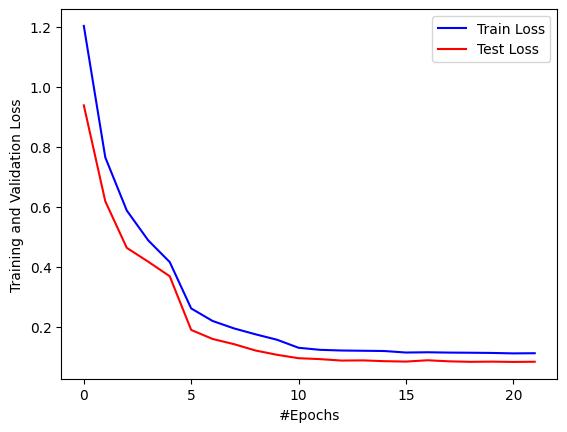

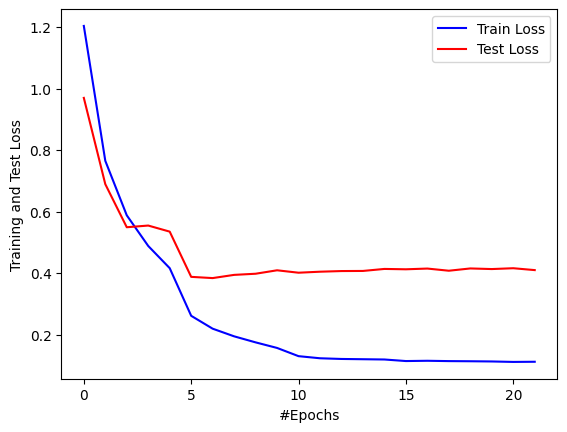

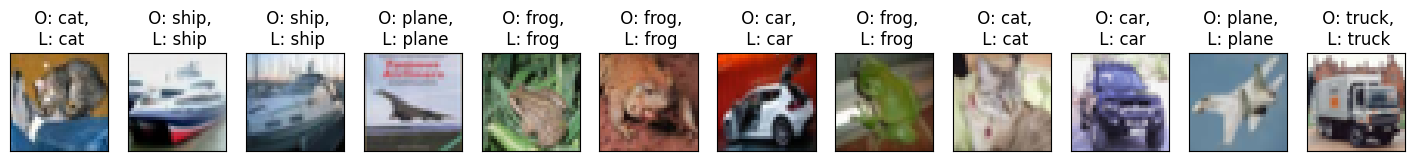

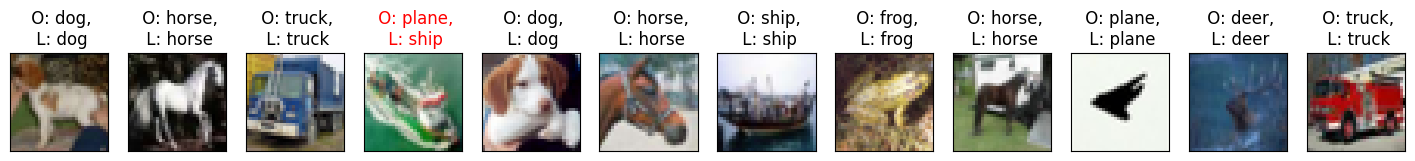

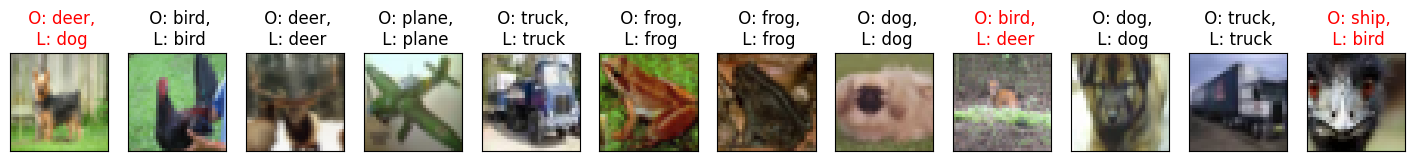

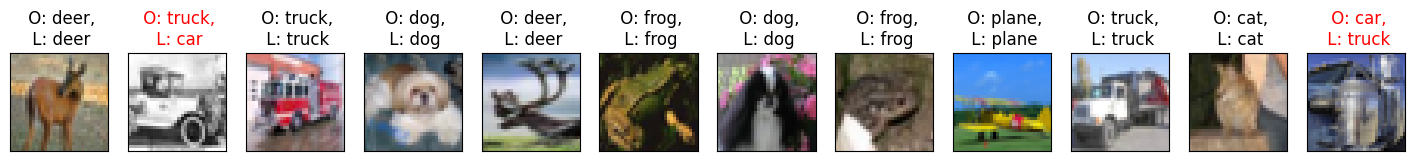

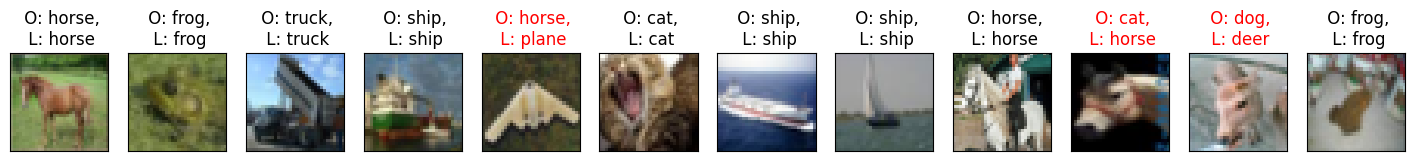

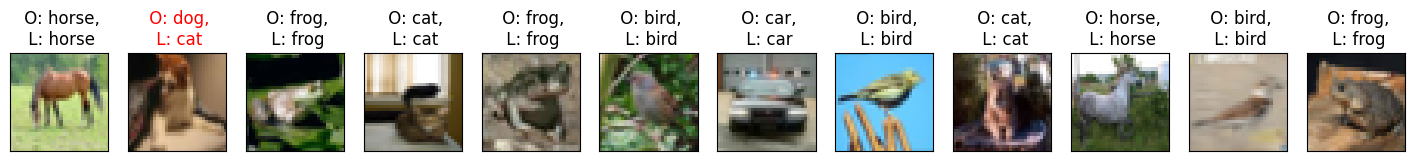

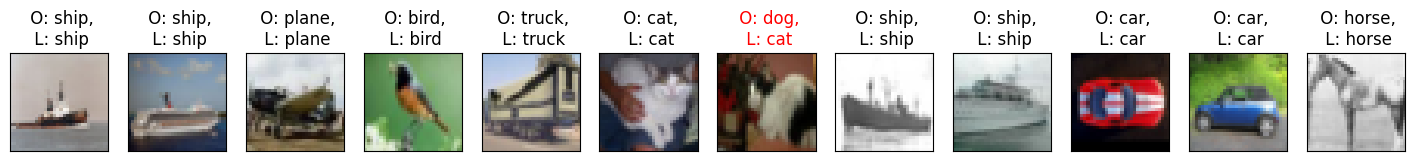

In [ ]:

#Training parameters
num_epochs = 22
print_interval = 1
learning_rate = 0.002
batch_size = 64
weight_decay = 1e-4

#Create model
#network = Conv_Res_Net_basic(image_w, image_h, 10)
#network = ResNet(image_w, image_h, 10)
# network = myResNet()
network = DenseNet(10,[6,6,6,6],2,16)
network = network.to(device)

print("Num. Parameters:", count_parameters(network))

#Set optimizer and loss function
optimizer = torch.optim.AdamW(network.parameters(), lr=learning_rate, weight_decay = 1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
loss_function = nn.CrossEntropyLoss()

#Load the data, and split it into batches
training_generator = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
testing_generator = torch.utils.data.DataLoader(testing_dataset, batch_size=batch_size, shuffle=False)

print("Data is Loaded")

#trainAndGraph(network, training_generator, testing_generator, loss_function, optimizer, num_epochs, learning_rate, print_interval)
trainAndGraph(network, training_generator, validation_generator, testing_generator, loss_function, optimizer, num_epochs, learning_rate, print_interval)


computeLabelAccuracy(network, training_generator, "Train Set")
computeLabelAccuracy(network, testing_generator, "Test Set")
drawPredictionsCIFAR10(network, testing_dataset, 7, 12, 0)

Files already downloaded and verified
Accuracy of the network on the 10000 test images: 87.23%


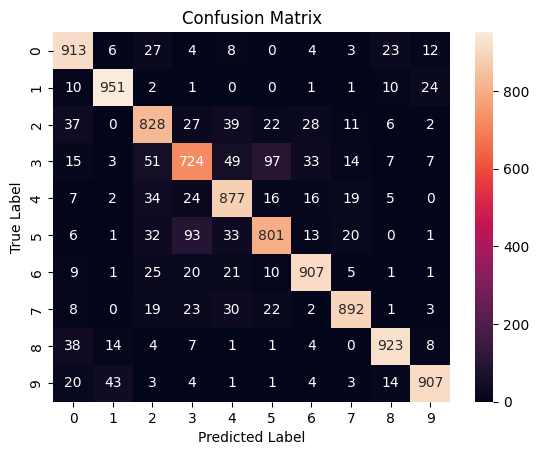

In [ ]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

model = DenseNet()
model.load_state_dict(torch.load('best_model.pt'))

# Set the model to evaluation mode
model.eval()

# Initialize variables for calculating accuracy and confusion matrix
correct = 0
total = 0
all_labels = []
all_predictions = []

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Calculate accuracy
accuracy = 100 * correct / total
print(f'Accuracy of the network on the 10000 test images: {accuracy}%')

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
import torch
from torch.optim.swa_utils import AveragedModel, update_bn
from torch.nn import functional as F

class SWADenseNet(nn.Module):
    def __init__(self, trained_model, lr=0.01):
        super().__init__()
        self.model = trained_model
        self.swa_model = AveragedModel(self.model)
        self.optimizer = torch.optim.SGD(
            self.model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4
        )

    def forward(self, x):
        return self.swa_model(x)

    def train_one_epoch(self, train_loader):
        self.model.train()
        for x, y in train_loader:
            self.optimizer.zero_grad()
            output = self.model(x)
            loss = F.cross_entropy(output, y)
            loss.backward()
            self.optimizer.step()
            self.swa_model.update_parameters(self.model)

    def evaluate(self, loader):
        self.swa_model.eval()
        total_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for x, y in loader:
                output = self.swa_model(x)
                total_loss += F.cross_entropy(output, y).item()
                predictions = output.max(1, keepdim=True)[1]
                correct += predictions.eq(y.view_as(predictions)).sum().item()
                total += y.size(0)
        avg_loss = total_loss / total
        accuracy = 100. * correct / total
        return avg_loss, accuracy

    def update_bn(self, train_loader):
        update_bn(train_loader, self.swa_model)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

class ResNetModel(nn.Module):
    def __init__(self, lr=0.05):
        super().__init__()
        self.lr = lr
        self.model = create_model()  # Assuming create_model() is defined elsewhere

    def forward(self, x):
        out = self.model(x)
        return torch.log_softmax(out, dim=1)

    def train_one_epoch(self, train_loader, optimizer, criterion):
        self.train()
        total_loss = 0
        for batch_idx, (x, y) in enumerate(train_loader):
            optimizer.zero_grad()
            logits = self(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        return avg_loss

    def evaluate(self, loader, criterion):
        self.eval()
        total_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for x, y in loader:
                logits = self(x)
                loss = criterion(logits, y)
                total_loss += loss.item()
                preds = torch.argmax(logits, dim=1)
                correct += (preds == y).sum().item()
                total += y.size(0)
        avg_loss = total_loss / len(loader)
        accuracy = correct / total
        return avg_loss, accuracy

# Example Usage
model = ResNetModel()
optimizer = optim.SGD(model.parameters(), lr=model.lr, momentum=0.9, weight_decay=5e-4)
criterion = nn.NLLLoss()

train_loader = DataLoader(...)  # Define your data loader
val_loader = DataLoader(...)    # Define your data loader

# Training loop
for epoch in range(num_epochs):
    train_loss = model.train_one_epoch(train_loader, optimizer, criterion)
    val_loss, val_accuracy = model.evaluate(val_loader, criterion)
    print(f"Epoch: {epoch}, Train Loss: {train_loss}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}")

    # Update learning rate scheduler if necessary


Num. Parameters: 478292
Data is Loaded
Batch [200/781], Train Loss: 0.2969
Batch [400/781], Train Loss: 0.3001
Batch [600/781], Train Loss: 0.3035
Epoch [1/6], Train Loss: 0.3076, Validation Loss: 0.2309, Test Loss: 0.4662
Batch [200/781], Train Loss: 0.2465
Batch [400/781], Train Loss: 0.2634
Batch [600/781], Train Loss: 0.2746
Epoch [2/6], Train Loss: 0.2798, Validation Loss: 0.1879, Test Loss: 0.4633
Batch [200/781], Train Loss: 0.2216
Batch [400/781], Train Loss: 0.2352
Batch [600/781], Train Loss: 0.2378
Epoch [3/6], Train Loss: 0.2463, Validation Loss: 0.1780, Test Loss: 0.4830
Batch [200/781], Train Loss: 0.1940
Batch [400/781], Train Loss: 0.2079
Batch [600/781], Train Loss: 0.2146
Epoch [4/6], Train Loss: 0.2173, Validation Loss: 0.1515, Test Loss: 0.4662
Batch [200/781], Train Loss: 0.1755
Batch [400/781], Train Loss: 0.1863
Batch [600/781], Train Loss: 0.1925
Epoch [5/6], Train Loss: 0.1935, Validation Loss: 0.1571, Test Loss: 0.5109
Batch [200/781], Train Loss: 0.1154
Batch

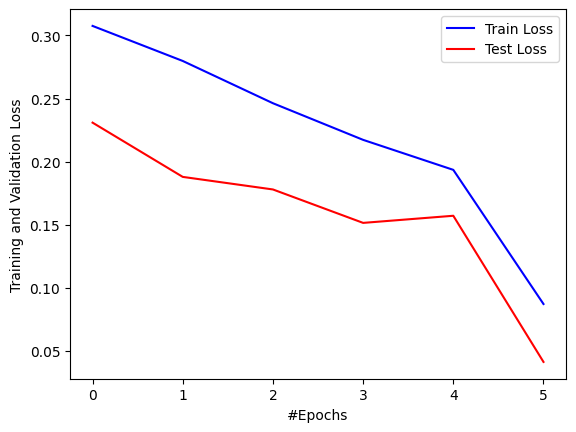

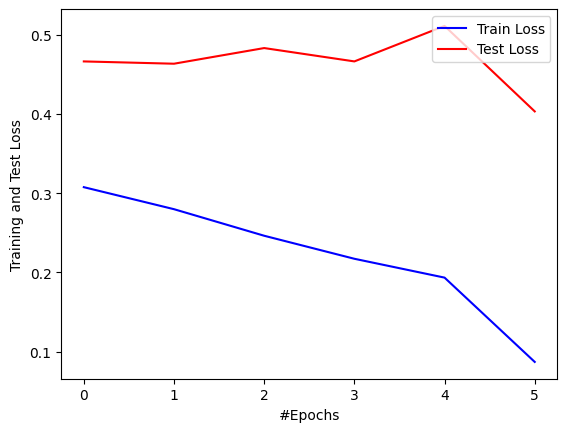

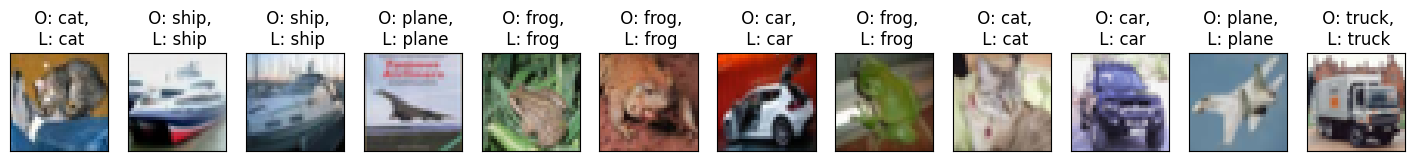

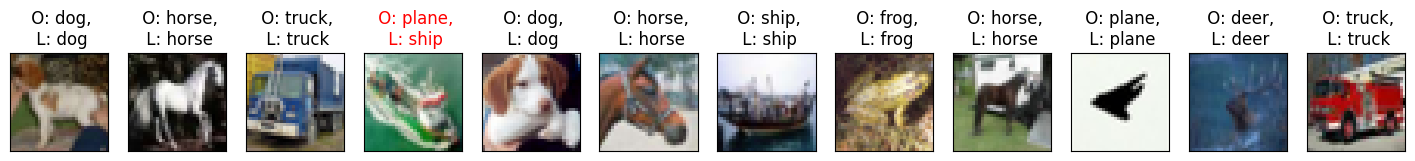

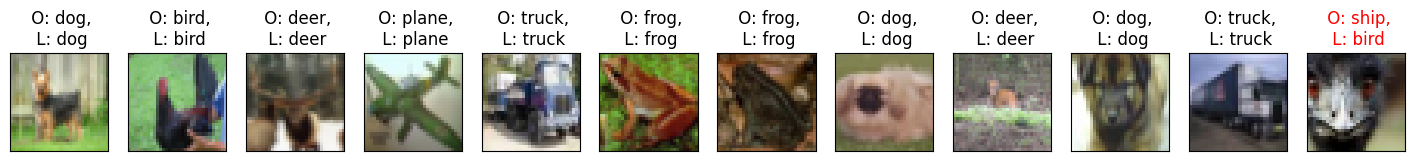

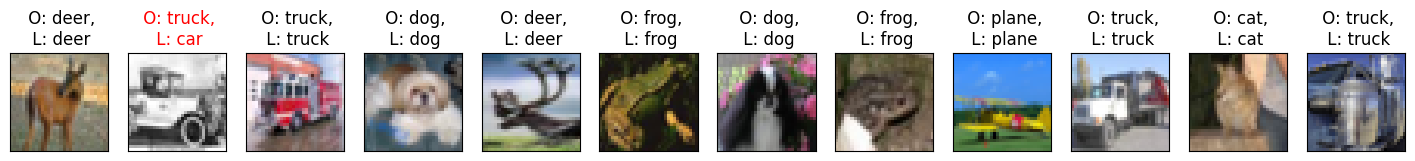

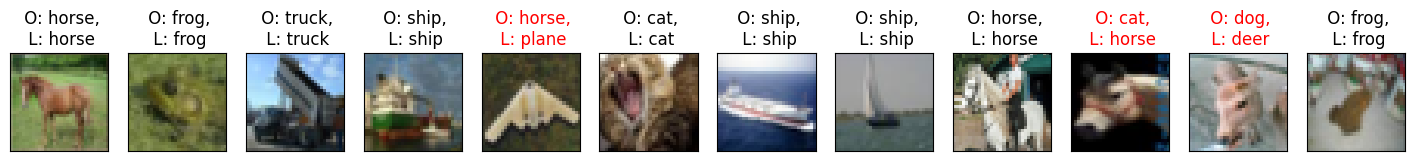

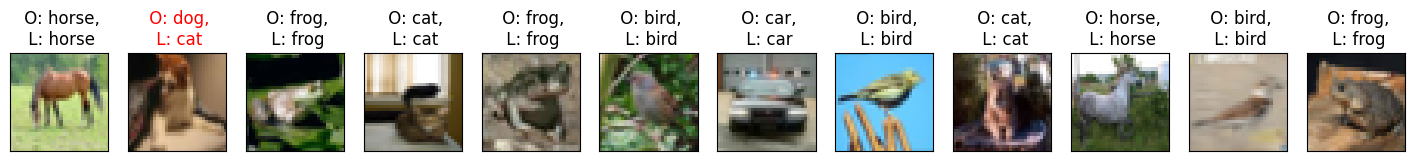

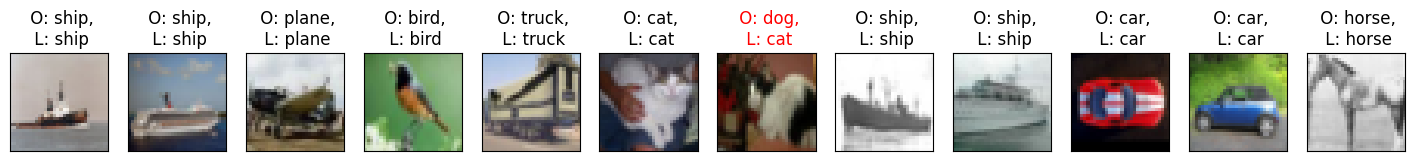

In [ ]:

#Training parameters
num_epochs = 6
print_interval = 1
learning_rate = 0.002
batch_size = 64
weight_decay = 1e-4


# Load the adjusted state dictionary into your SWADenseNet model's swa_model
model = DenseNet()
model.load_state_dict(torch.load('mybest_model.pt'))
swa_network = SWADenseNet(model)

# Set device
swa_network = swa_network.to(device)


# Set device
# swa_network = swa_network.to(device)
print("Num. Parameters:", count_parameters(swa_network))

# Set optimizer, scheduler, and loss function
optimizer = torch.optim.AdamW(swa_network.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
loss_function = nn.CrossEntropyLoss()

# Load the data
training_generator = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
validation_generator = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
testing_generator = torch.utils.data.DataLoader(testing_dataset, batch_size=batch_size, shuffle=False)

print("Data is Loaded")

#trainAndGraph(network, training_generator, testing_generator, loss_function, optimizer, num_epochs, learning_rate, print_interval)
trainAndGraph(swa_network, training_generator, validation_generator, testing_generator, loss_function, optimizer, num_epochs, learning_rate, print_interval)


# Compute accuracy
computeLabelAccuracy(swa_network, training_generator, "Train Set")
computeLabelAccuracy(swa_network, testing_generator, "Test Set")

# Visualize predictions
drawPredictionsCIFAR10(swa_network, testing_dataset, 7, 12, 0)

# # Update Batch Normalization for SWA model at the end
# swa_network.update_bn(training_generator)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
swa_network = swa_network.to(device)

# When using the model for training or updating batch normalization
for inputs, targets in training_generator:
    inputs, targets = inputs.to(device), targets.to(device)
    # Your training or batch normalization update logic goes here

# Updating batch normalization for SWA model
swa_network.update_bn(training_generator)


RuntimeError: ignored